Датасет: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

# 1) Завантажити дані, вивести назви колонок і розмір датасета

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

data = pd.read_csv('heart.csv')

# Виведення назв колонок і розміру датасету
columns = data.columns.tolist()
shape = data.shape

columns, shape


(['Age',
  'Sex',
  'ChestPainType',
  'RestingBP',
  'Cholesterol',
  'FastingBS',
  'RestingECG',
  'MaxHR',
  'ExerciseAngina',
  'Oldpeak',
  'ST_Slope',
  'HeartDisease'],
 (918, 12))

 Датасет має 12 колонок, які мають числові та категоріальні змінні, а також цільову змінну HeartDisease. Розмір датасету - 918 рядків і 12 колонок.

# 2) Опрацювати пропуски (по можливості заповнити їх або видалити)

In [7]:
data.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

# 3) Візуалізувати дані: побудувати графік (heatmap), що відображає кореляції ознак між собою і з цільовою змінною (розміткою); побудувати гістограми розподілу ознак і boxplot-и ознак відносно цільової змінної (якщо ознак занадто багато обмежитися декількома)

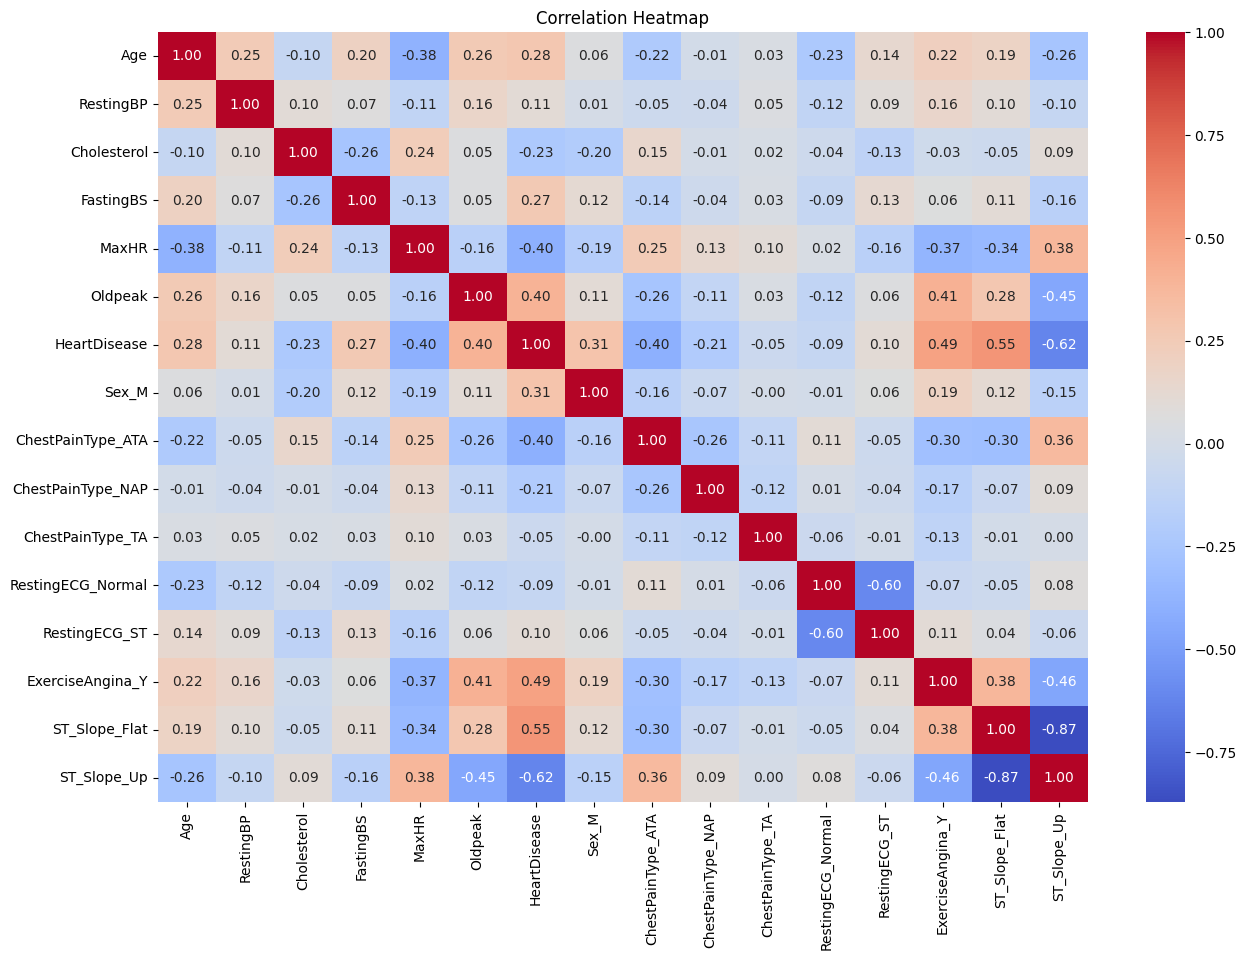

In [9]:
# Кодування категоріальних змінних
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
data_encoded = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# Побудова теплової карти кореляцій для числових змінних
plt.figure(figsize=(15, 10))
correlation_matrix = data_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation Heatmap")
plt.show()


Heatmap показує взаємозв’язки між усіма числовими змінними, включаючи закодовані категоріальні змінні. Цільова змінна HeartDisease показує сильний кореляційний зв’язок із деякими ознаками (Oldpeak та ST_Slope_Up), тоді як інші ознаки, такі як MaxHR, демонструють негативний кореляційний зв’язок.

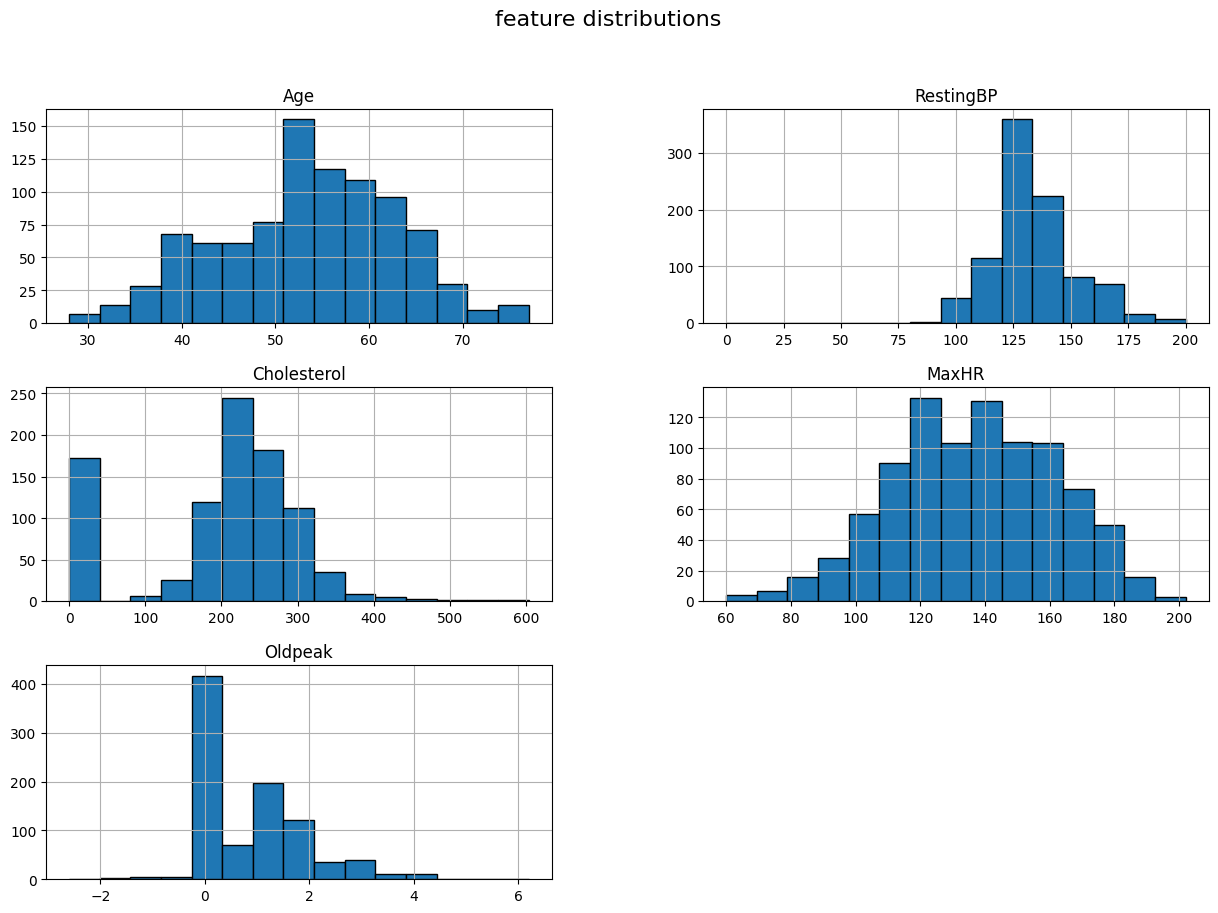

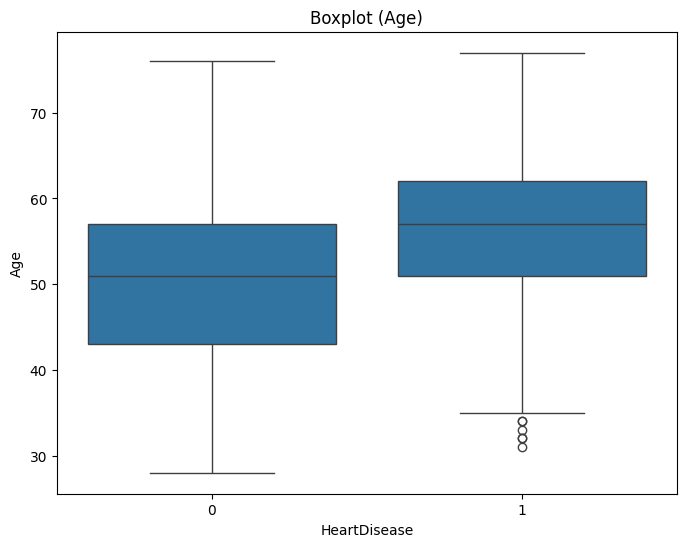

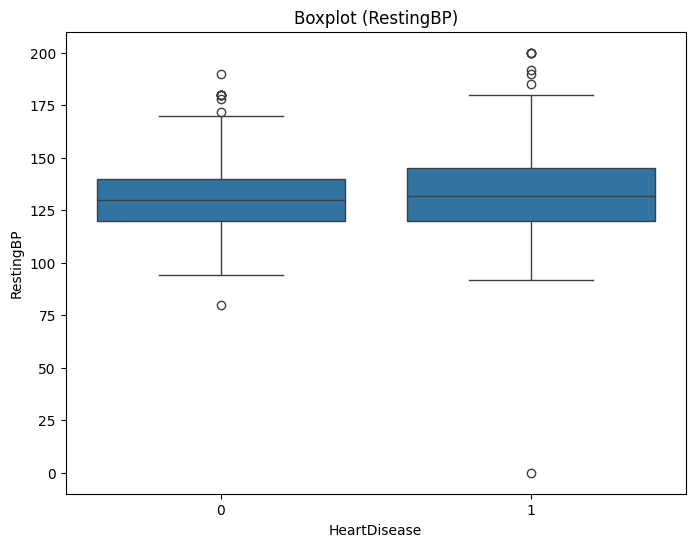

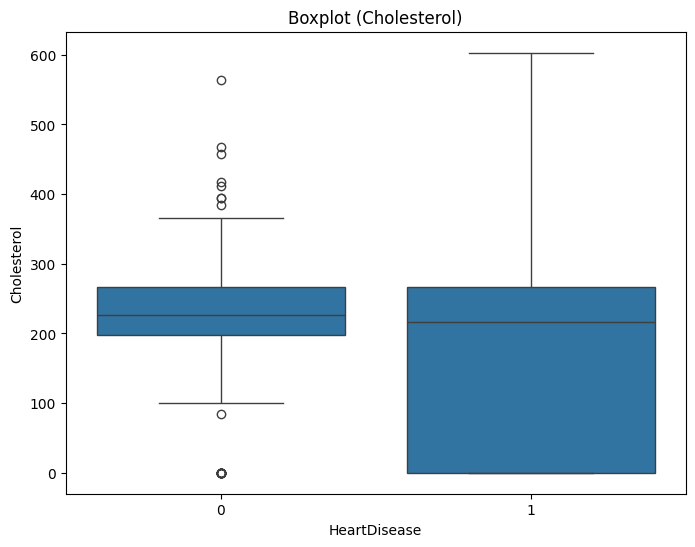

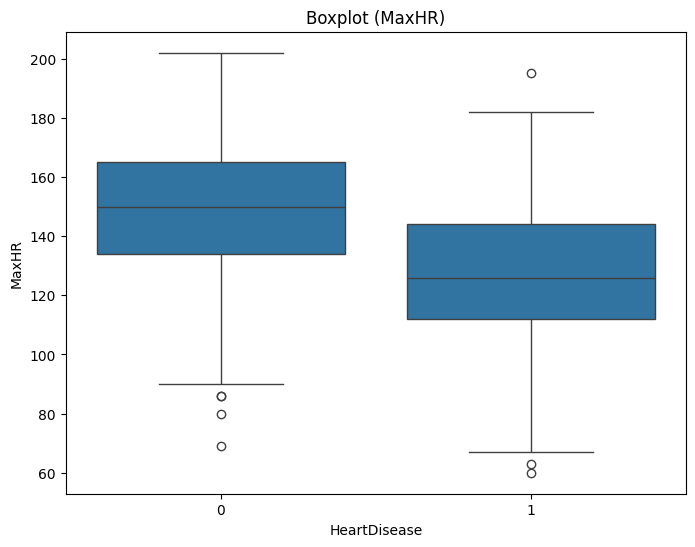

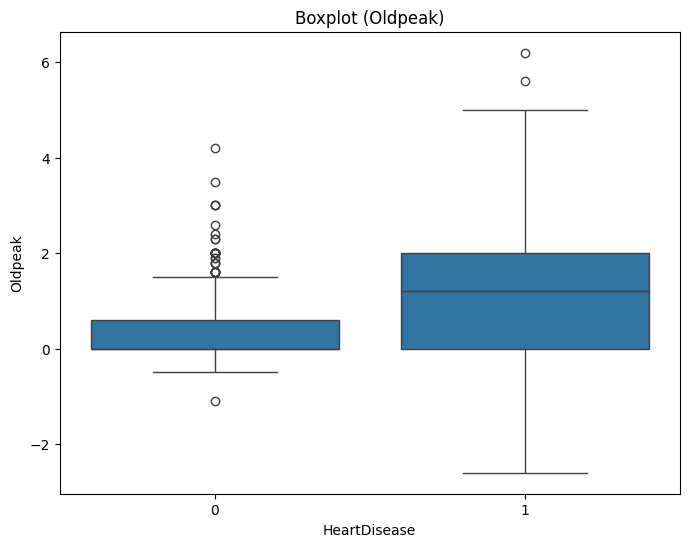

In [12]:
# Побудова гістограм розподілу для вибраних ознак
selected_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

data[selected_features].hist(bins=15, figsize=(15, 10), edgecolor='black')
plt.suptitle('feature distributions', fontsize=16)
plt.show()

# Побудова boxplot для вибраних ознак відносно цільової змінної
for feature in selected_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data['HeartDisease'], y=data[feature])
    plt.title(f'Boxplot ({feature})')
    plt.xlabel('HeartDisease')
    plt.ylabel(feature)
    plt.show()


Гістограми показують розподіл значень вибраних ознак, таких як Age, RestingBP, Cholesterol, MaxHR, та Oldpeak. Наприклад, Age має нормальний розподіл, а Oldpeak зміщений до нуля. Boxplot-и виявляють, як ознаки змінюються залежно від значення HeartDisease. MaxHR значно нижчий для пацієнтів із серцевими захворюваннями.

# 4) Нормалізувати дані

In [13]:
# Нормалізація числових ознак
features_to_normalize = data.select_dtypes(include=['float64', 'int64']).drop(columns=['HeartDisease']).columns

scaler = StandardScaler()
data[features_to_normalize] = scaler.fit_transform(data[features_to_normalize])

data[features_to_normalize].head()


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
0,-1.433140,0.410909,0.825070,-0.551341,1.382928,-0.832432
1,-0.478484,1.491752,-0.171961,-0.551341,0.754157,0.105664
2,-1.751359,-0.129513,0.770188,-0.551341,-1.525138,-0.832432
3,-0.584556,0.302825,0.139040,-0.551341,-1.132156,0.574711
4,0.051881,0.951331,-0.034755,-0.551341,-0.581981,-0.832432


Числові ознаки було нормалізовано за допомогою методу StandardScaler, що показує середнє значення 0 і стандартне відхилення 1 для кожної ознаки. Це дає змогу вирівняти масштаби різних змінних.

In [14]:
# Розділення даних на ознаки та цільову змінну
X = data_encoded.drop(columns=['HeartDisease'])
y = data_encoded['HeartDisease']

# Розподіл на навчальну і тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((642, 15), (276, 15), (642,), (276,))

Навчальна вибірка має 642 рядки, а тестова - 276. Після кодування категоріальних ознак кількість ознак збільшилась до 15

# 5) Провести навчання наступних класифікаторів:
	•	kNN
	•	дерево ухвалення рішень
	•	SVM
	•	Random Forest
	•	AdaBoost

In [15]:
# Ініціалізація моделей
models = {
    'kNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

# Навчання та оцінка моделей
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    results[name] = {'report': report, 'confusion_matrix': cm}

results

/Users/philip/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'kNN': {'report': {'0': {'precision': 0.6666666666666666,
    'recall': 0.6666666666666666,
    'f1-score': 0.6666666666666666,
    'support': 123.0},
   '1': {'precision': 0.7320261437908496,
    'recall': 0.7320261437908496,
    'f1-score': 0.7320261437908496,
    'support': 153.0},
   'accuracy': 0.7028985507246377,
   'macro avg': {'precision': 0.6993464052287581,
    'recall': 0.6993464052287581,
    'f1-score': 0.6993464052287581,
    'support': 276.0},
   'weighted avg': {'precision': 0.7028985507246377,
    'recall': 0.7028985507246377,
    'f1-score': 0.7028985507246377,
    'support': 276.0}},
  'confusion_matrix': array([[ 82,  41],
         [ 41, 112]])},
 'Decision Tree': {'report': {'0': {'precision': 0.7795275590551181,
    'recall': 0.8048780487804879,
    'f1-score': 0.792,
    'support': 123.0},
   '1': {'precision': 0.8389261744966443,
    'recall': 0.8169934640522876,
    'f1-score': 0.8278145695364238,
    'support': 153.0},
   'accuracy': 0.8115942028985508,
   '

Random Forest показав найкращі результати серед інших:
- Точність: 88.77%.
- F1-score для класу 1: 90.03%.
- Confusion matrix: дуже мала кількість помилкових передбачень для обох класів.

AdaBoost також має високу точність (84.78%).

kNN і SVM продемонстрували середні результати з точністю 70.29% і 72.46% відповідно.

# Підібрати оптимальні параметри
- для kNN
- для SVM за допомогою GridSearch підібрати оптимальні «C» і «gamma»

Серед обраних оптимальних моделей кожного класу вибрати найкращу.

In [19]:
# GridSearch для kNN
knn_params = {'n_neighbors': range(1, 21)}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy')
knn_grid.fit(X_train, y_train)

# GridSearch для SVM
svm_params = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}
svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy')
svm_grid.fit(X_train, y_train)

knn_best_params = knn_grid.best_params_
knn_best_score = knn_grid.best_score_

svm_best_params = svm_grid.best_params_
svm_best_score = svm_grid.best_score_

knn_best_params, knn_best_score, svm_best_params, svm_best_score


({'n_neighbors': 7},
 np.float64(0.7040213178294573),
 {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'},
 np.float64(0.7336361434108527))

Параметри покращили продуктивність моделей, але точність залишається нижчою, ніж у моделі Random Forest

# Відобразити sklearn.metrics.classification_report і sklearn.metrics.confusion_matrix

In [20]:
# SVM з кращими параметрами
best_svm = SVC(C=svm_best_params['C'], gamma=svm_best_params['gamma'], kernel=svm_best_params['kernel'])
best_svm.fit(X_train, y_train)

y_pred_svm = best_svm.predict(X_test)
svm_report = classification_report(y_test, y_pred_svm)
svm_confusion_matrix = confusion_matrix(y_test, y_pred_svm)

svm_report, svm_confusion_matrix


('              precision    recall  f1-score   support\n\n           0       0.72      0.75      0.74       123\n           1       0.79      0.77      0.78       153\n\n    accuracy                           0.76       276\n   macro avg       0.76      0.76      0.76       276\nweighted avg       0.76      0.76      0.76       276\n',
 array([[ 92,  31],
        [ 35, 118]]))

- Точність моделі: 76%
- F1-score:
  - Для класу 0: 0.74 (баланс між точністю 72% і повнотою 75%)
  - Для класу 1: 0.78 (баланс між точністю 79% і повнотою 77%)
- Матриця плутанини:
  - Клас 0: 92 правильних передбачення та 31 помилкове
  - Клас 1: 118 правильних передбачення та 35 помилкових
